In [2]:
from platform import python_version
print(python_version())

3.6.12


In [4]:
install_packages = False
if install_packages:    
    !conda install -c conda-forge umap-learn -y
    !conda install -c conda-forge scikit-learn-extra -y

In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

In [2]:
def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')

In [4]:
# Set pandas print options
#This will improve readability of printed pandas dataframe.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [5]:
output_path = "./output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

In [6]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [7]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [8]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

n_clusters: 2 silhouette_avg: 0.20810421
n_clusters: 102 silhouette_avg: 0.1623729


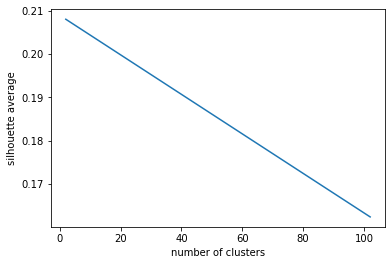

In [45]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=142 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

In [46]:
number_of_clusters =  3
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 0    44
2    46
1    52
Name: label_kmedoids, dtype: int64


In [50]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

In [13]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

C:\Users\Alex\anaconda3\envs\MyEnv\lib\site-packages\umap\umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


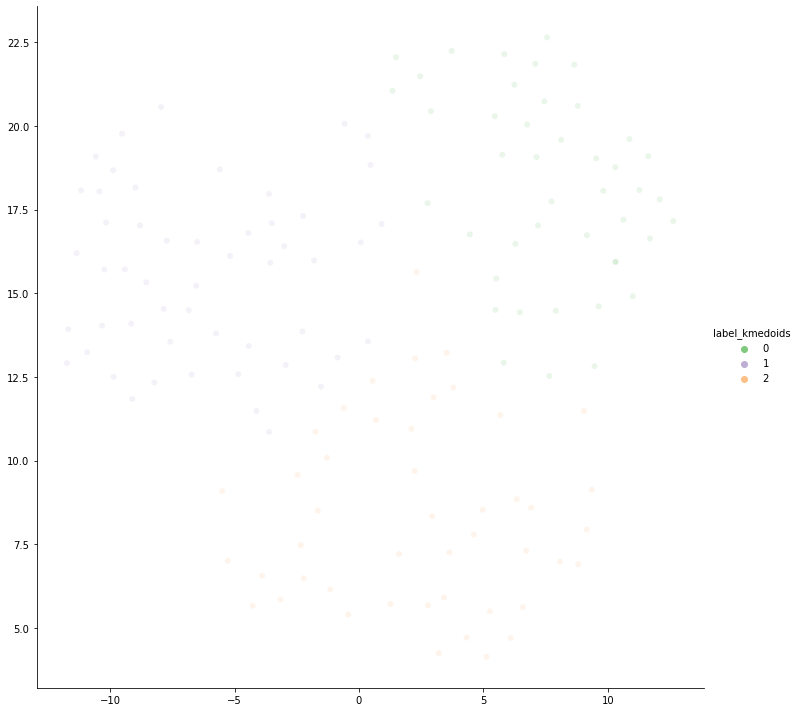

In [48]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "Accent" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)

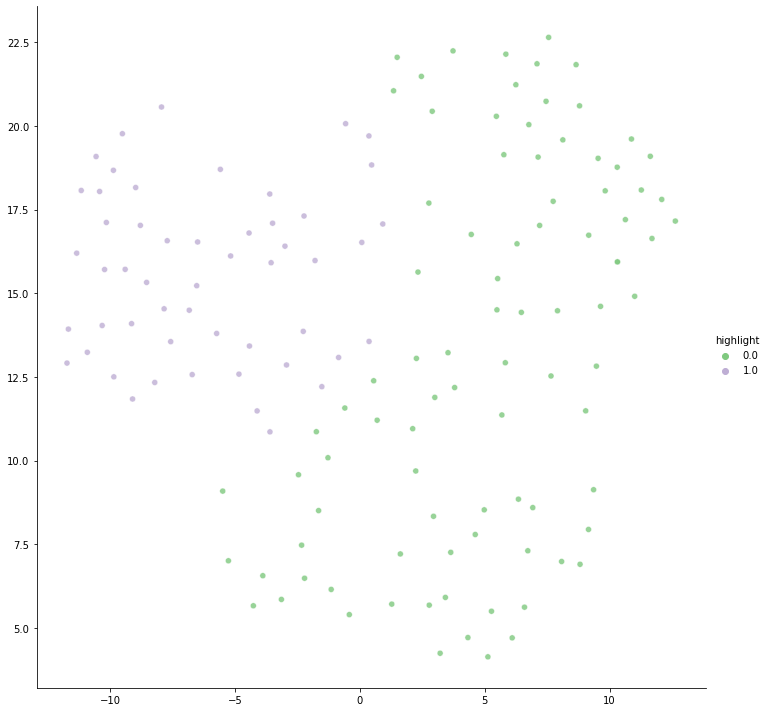

In [49]:
## Choose a cluster to higlight:
cluster_num = 1

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)

In [51]:
# print the medoids 
data.iloc[medoids_indices]

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
53,2020-07-23 20:15:38,dannzman,Nailed it once again Rand Paul ! Cuomo is a complete incompetent joke!,0,Nailed it once again Rand Paul ! Cuomo is a complete incompetent joke!\n\n,-1,0,0.000000e+00,0.0
97,2020-07-23 16:06:15,Alabama Mothman,"Peas and rice, they have already caught the CDC falsifying positive test results. But FN keeps vomiting up up the same old lies, like we didnt know this. All to keep us in fear to keep the economy shut down to hurt Trump.",0,"Peas and rice, they have already caught the CDC falsifying positive test\nresults. But FN keeps vomiting up up the same old lies, like we didnt know\nthis. All to keep us in fear to keep the economy shut down to hurt Trump.\n\n",-1,1,0.000000e+00,1.0
114,2020-07-23 15:56:22,Firebird 7479,Birx blaming everything but the riots.,0,Birx blaming everything but the riots.\n\n,-1,2,5.960464e-08,0.0


In [17]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  1 mean distance from center:  0.0 Proportion of replies: 100.0
1 number of samples:  1 mean distance from center:  0.0 Proportion of replies: 0.0
2 number of samples:  1 mean distance from center:  0.0 Proportion of replies: 0.0
3 number of samples:  1 mean distance from center:  0.0 Proportion of replies: 100.0
4 number of samples:  1 mean distance from center:  5.9604644775390625e-06 Proportion of replies: 100.0
5 number of samples:  2 mean distance from center:  0.0005781650543212891 Proportion of replies: 0.0
6 number of samples:  3 mean distance from center:  0.0007748603820800781 Proportion of replies: 33.333333333333336
7 number of samples:  2 mean distance from center:  0.00042617321014404297 Proportion of replies: 50.0
8 number of samples:  1 mean distance from center:  5.9604644775390625e-06 Proportion of replies: 0.0
9 number of samples:  1 mean distance from center:  2.9802322387695312e-05 Proportion of replies: 100.0
10 number of samples:  1 mean dist

In [61]:
# Choose a cluster to print
cluster_number =   1
# Choose the number of samples to print
number_of_samples_to_print = 142

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))

Number of samples in the cluster: 52
Average Distance from cluster center: 0.0001788403


In [65]:
#which cluster would you like to assign labels to?
cluster_number = 1
#your label
label_manual = 'conspiracies'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 0.000000001

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [66]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
97,2020-07-23 16:06:15,Alabama Mothman,"Peas and rice, they have already caught the CDC falsifying positive test results. But FN keeps vomiting up up the same old lies, like we didnt know this. All to keep us in fear to keep the economy shut down to hurt Trump.",0,"Peas and rice, they have already caught the CDC falsifying positive test\nresults. But FN keeps vomiting up up the same old lies, like we didnt know\nthis. All to keep us in fear to keep the economy shut down to hurt Trump.\n\n",conspiracies,1,0.000000,1.0
58,2020-07-23 18:44:37,Robert Ganther,"These people are morons... There is no proof that a virus has &quot;EVER&quot; killed or made anyone sick, This is however about Agenda 21 and the new world order !",0,"These people are morons... There is no proof that a virus has ""EVER"" killed or\nmade anyone sick, This is however about Agenda 21 and the new world order !\n\n",conspiracies,1,0.000024,1.0
87,2020-07-25 01:37:04,Mark G,"@USF Fan Needed for what, COVID-1984? A few years ago in TX over 11,000 people died from the flu, so far it's just over 3k from this bs.. Got that from Ron Paul's channel btw, looked up the stats on the cdc website myself.. Wake up man..",1,"@ Needed for what, COVID-1984? A few years ago in TX over 11,000 people\ndied from the flu, so far it's just over 3k from this bs.. Got that from Ron\nPaul's channel btw, looked up the stats on the cdc website myself.. Wake up\nman..\n\n",conspiracies,1,0.000024,1.0
137,2020-07-23 15:38:26,Teresa Miller,Why are people getting tested if they are not sick. Because they don&#39;t want to work. You don&#39;t work you don&#39;t eat. They want to destroy our country.,0,Why are people getting tested if they are not sick. Because they don't want to\nwork. You don't work you don't eat. They want to destroy our country.\n\n,conspiracies,1,0.000047,1.0
32,2020-07-24 17:54:07,Patricia Taylor,"After looking at the current conditions in other countries, it seems that many have managed to contain the virus in such a way that we haven&#39;t in the US. There must be something to learn..",0,"After looking at the current conditions in other countries, it seems that many\nhave managed to contain the virus in such a way that we haven't in the US.\nThere must be something to learn..\n\n",conspiracies,1,0.000065,1.0
22,2020-08-09 19:09:57,Deborah Evans,"Thank Y-h...one more besides myself that knows this shutting down, is ridiculous. It is important not to group on in close quarters. This thing is like the common cold, we can’t contain it.",0,"Thank Y-h...one more besides myself that knows this shutting down, is\nridiculous. It is important not to group on in close quarters. This thing is\nlike the common cold, we can’t contain it.\n\n",conspiracies,1,0.000075,1.0
7,2020-09-23 23:54:10,Sustainable Goddess,"Not true... just boost your immune system. Take HCQ with Zinc, Take 5,000 mgs of C and D for a week, go vegan, use peroxide therapy. It&#39;s just a damn cold!!! We don&#39;t need a vaccines... they don&#39;t work on toxic poisoning. Why is everyone in charge lying???",0,"Not true... just boost your immune system. Take HCQ with Zinc, Take 5,000 mgs\nof C and D for a week, go vegan, use peroxide therapy. It's just a damn\ncold!!! We don't need a vaccines... they don't work on toxic poisoning. Why is\neveryone in charge lying???\n\n",conspiracies,1,0.000075,1.0
86,2020-07-25 04:03:20,USF Fan,"@Mark G I'm on the same side you are. Skeptical about this whole thing and I dont need a vaccine because I'm healthy. For some people with immune deficiencies, it might be worth considering, but like I said, not mandated, and not rushed. Not required. Hope that makes sense",1,"@ I'm on the same side you are. Skeptical about this whole thing and I\ndont need a vaccine because I'm healthy. For some people with immune\ndeficiencies, it might be worth considering, but like I said, not mandated,